# Pokemon GAN Training Notebook

## **Import libraries**

In [213]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import PokemonGensDataset
from ACGAN import AuxGAN
from utils import show_tensor_images, flatten_dict, return_tensor_images
import variable as var
import os
import cuda_monitoring as cuda_mon
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [66]:
cuda_mon.get_tensor_info()
cuda_mon.get_gpu_memory_info()

/home/benoit/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/home/benoit/anaconda3/lib/python3.7/importlib/__init__.py:127: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  return _bootstrap._gcd_import(name[level:], package, level)


<class 'torch.Tensor'> 	 cpu 	 6.0 MB (128, 3, 64, 64) 	
<class 'torch.Tensor'> 	 cpu 	 1.07 KB (128,) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 200.0 B (1, 32) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 76.0 B (1,) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 2.32 KB (18, 32) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 144.0 B (18,) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 6.07 KB (32, 3, 4, 4) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 512.07 KB (32, 256, 4, 4) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 128.07 KB (64, 32, 4, 4) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 328.0 B (64,) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 328.0 B (64,) 	
<class 'torch.Tensor'> 	 cuda:0 	 328.0 B (64,) 	
<class 'torch.Tensor'> 	 cuda:0 	 328.0 B (64,) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 512.07 KB (128, 64, 4, 4) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 584.0 B (128,) 	
<class 'torch.nn.param

<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 1.82 KB (448,) 	
<class 'torch.Tensor'> 	 cuda:0 	 1.82 KB (448,) 	
<class 'torch.Tensor'> 	 cuda:0 	 1.82 KB (448,) 	
<class 'torch.Tensor'> 	 cuda:0 	 80.0 B () 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 5.91 MB (384, 448, 3, 3) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 1.57 KB (384,) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 1.57 KB (384,) 	
<class 'torch.Tensor'> 	 cuda:0 	 1.57 KB (384,) 	
<class 'torch.Tensor'> 	 cuda:0 	 1.57 KB (384,) 	
<class 'torch.Tensor'> 	 cuda:0 	 80.0 B () 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 1.69 MB (384, 384, 1, 3) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 1.57 KB (384,) 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 1.57 KB (384,) 	
<class 'torch.Tensor'> 	 cuda:0 	 1.57 KB (384,) 	
<class 'torch.Tensor'> 	 cuda:0 	 1.57 KB (384,) 	
<class 'torch.Tensor'> 	 cuda:0 	 80.0 B () 	
<class 'torch.nn.parameter.Parameter'> 	 cuda:0 	 1.69 MB (384, 384

## **Load labels**

In [67]:
resume_training = True
train_number = 12
gan_id = f"acgan_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 128
print(f"Greyscale: {greyscale}")
print(f"Real: {resize_image_dim}x{resize_image_dim} images")
print(f"Fake: {2**(3 + n_conv_block)}x{2**(3 + n_conv_block)} images")

Greyscale: False
Real: 64x64 images
Fake: 64x64 images


In [68]:
dset = PokemonGensDataset(greyscale, resize=[resize_image_dim, resize_image_dim], gens_to_remove=("gen8", ))
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)

dloader = DataLoader(
    MNIST(os.environ['DATASETS'], 
          download=False, 
          transform=transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize([resize_image_dim, resize_image_dim])
                                       ])
         ), 
    batch_size=batch_size,
    shuffle=True)

In [69]:
len(dloader)*batch_size

6656

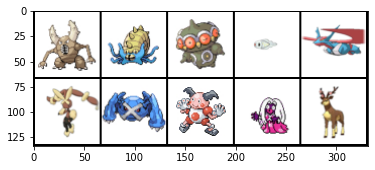

In [70]:
images, labels = next(iter(dloader))
show_tensor_images(images)

## **GAN Component**

In [71]:
betas = {'1': .5, '2': .999}
n_channel = 1 if greyscale else 3
n_feature = 32
z_dim = 100
n_classes = len(dset.label_map)
load_inception = False
    
params = {'gen': {'n_feature': int(n_feature),
                  'n_channel': int(n_channel),
                  'lr': 1e-4,
                  'betas': betas},
          'disc': {'n_channel': int(n_channel),
                   'n_feature': int(n_feature),
                   'lr': 1e-4,
                   'betas': betas},
          'z_dim': int(z_dim),
          'n_conv_block': int(n_conv_block),
          'n_classes': int(n_classes),
          'dataset': dset.describe(),
          'batch_size': int(batch_size)
         }

## **GAN INIT AND TRAINING**

In [72]:
gan = AuxGAN(params)
if os.path.exists(f'data/models/{gan_id}.pth'):
    print('RESUMING TRAINING...')
    gan.load_model(f'data/models/{gan_id}.pth')
else:
    print('NEW TRAINING...')
print(f'id: {gan_id}')

RESUMING TRAINING...
id: acgan_pokemon_train_12


In [73]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [153]:
gan.train(n_epoch=1000, dataloader=dloader, gan_id=gan_id+'checkpointmode')

100%|██████████| 1000/1000 [1:43:11<00:00,  6.19s/it]


## **RESULT VIZUALIZATION**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class: grass


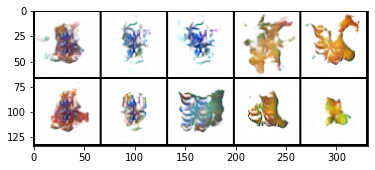

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.4
auxiliary precision: 0.5
--------------------------------------------------------------------------
class: fire


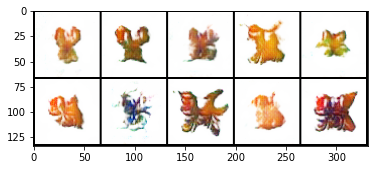

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.6
auxiliary precision: 0.9
--------------------------------------------------------------------------
class: water


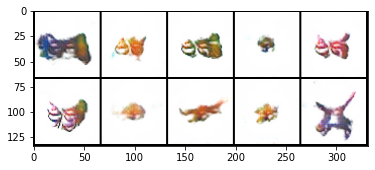

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.4
auxiliary precision: 1.0
--------------------------------------------------------------------------
class: bug


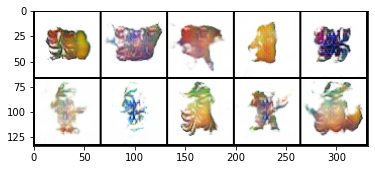

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.2
auxiliary precision: 0.1
--------------------------------------------------------------------------
class: normal


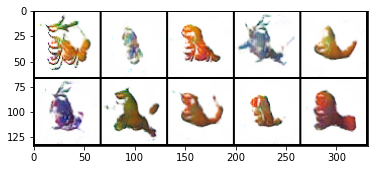

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.3
auxiliary precision: 1.0
--------------------------------------------------------------------------
class: poison


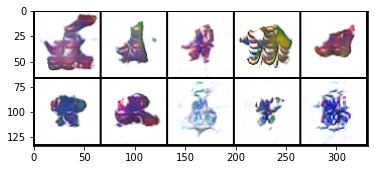

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.0
auxiliary precision: 0.9
--------------------------------------------------------------------------
class: electric


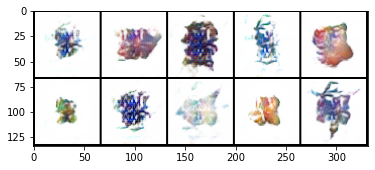

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.4
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: ground


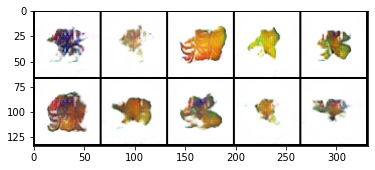

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.4
auxiliary precision: 1.0
--------------------------------------------------------------------------
class: fairy


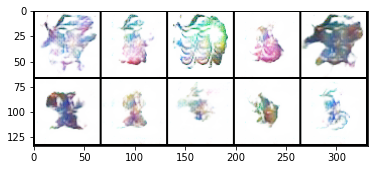

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.0
auxiliary precision: 0.7
--------------------------------------------------------------------------
class: fighting


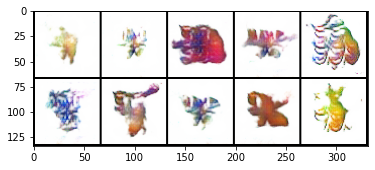

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.0
auxiliary precision: 0.9
--------------------------------------------------------------------------
class: psychic


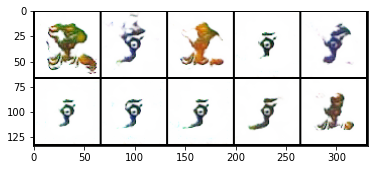

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.5
auxiliary precision: 1.0
--------------------------------------------------------------------------
class: rock


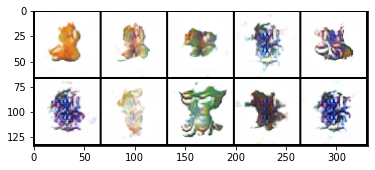

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.2
auxiliary precision: 0.9
--------------------------------------------------------------------------
class: ghost


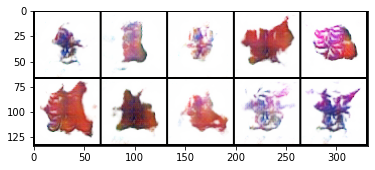

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.5
auxiliary precision: 0.7
--------------------------------------------------------------------------
class: ice


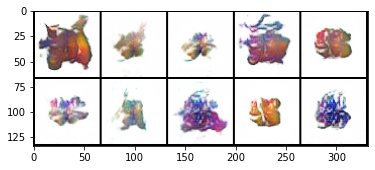

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.0
auxiliary precision: 0.7
--------------------------------------------------------------------------
class: dragon


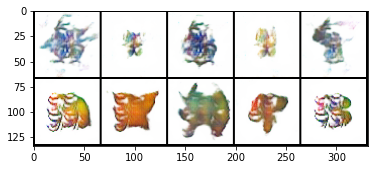

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.0
auxiliary precision: 0.1
--------------------------------------------------------------------------
class: dark


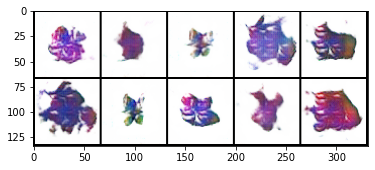

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.3
auxiliary precision: 0.6
--------------------------------------------------------------------------
class: steel


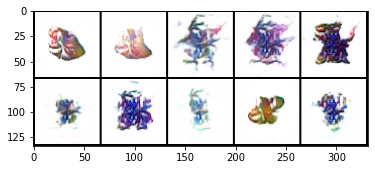

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake/real precision: 0.3
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: flying


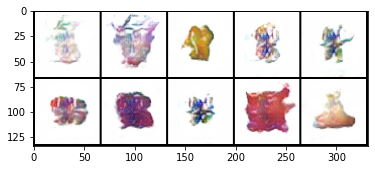

fake/real precision: 0.0
auxiliary precision: 0.0
--------------------------------------------------------------------------


In [154]:
for label_id, label_name in dset.label_map.items():
    print(f"class: {dset.label_map[label_id]}")
    with torch.no_grad():
        fakes, classes = gan.generate_fake(10, train=False, being_class=label_id)
        adv, aux = gan.discriminator(fakes)
        adv_label = adv < .5
        aux_label = torch.argmax(aux, dim=1) == classes.cuda()
    show_tensor_images(fakes)
    print(f"fake/real precision: {round((adv_label.sum()/ len(adv_label)).item(), 2)}")
    print(f"auxiliary precision: {round((aux_label.sum()/ len(aux_label)).item(), 2)}")
    print("--------------------------------------------------------------------------")

In [24]:
len(dset.label_map)

18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


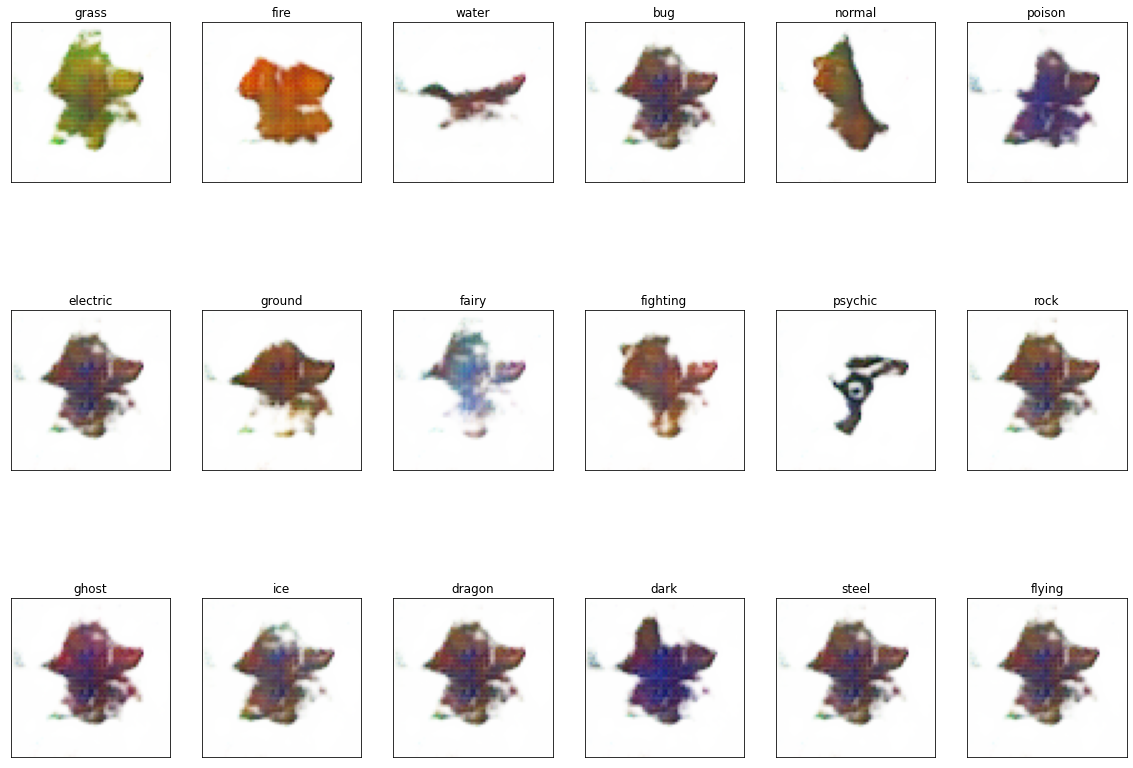

In [212]:
being_class = 9
n = 1
noise = torch.ones(n, z_dim, 1, 1, device=var.device) + 10
noise = gan.get_random_noise(n)
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=3, 
                                 ncols=6)
for idx, (label_id, label_name) in enumerate(dset.label_map.items()):
    with torch.no_grad():
        classes = torch.ones((n, ), device=var.device).long() * label_id
        gan.generator.eval()
        fakes = gan.generator.forward(noise, classes)
        
    i = idx // 6
    j = idx % 6
    axes[i][j].imshow(fakes[0].cpu().permute(1, 2, 0).numpy())
    axes[i][j].set_title(f"{dset.label_map[label_id]}")
    axes[i][j].xaxis.set_visible(False)
    axes[i][j].yaxis.set_visible(False)
    

In [209]:
fakes[0].cpu().permute(1, 2, 0).numpy().astype(np.float32)

array([[[0.9999815 , 0.9999716 , 0.99996984],
        [0.9999713 , 0.99998873, 0.9999471 ],
        [0.9999304 , 0.99994224, 0.999927  ],
        ...,
        [0.9995325 , 0.9996606 , 0.998859  ],
        [0.99991983, 0.9998214 , 0.99970895],
        [0.99935985, 0.9989638 , 0.9971397 ]],

       [[0.9999815 , 0.99994886, 0.99989146],
        [0.9999568 , 0.99995345, 0.99994236],
        [0.9986838 , 0.9990894 , 0.9993848 ],
        ...,
        [0.99986404, 0.99957985, 0.99959445],
        [0.99967504, 0.9994642 , 0.99954313],
        [0.99980414, 0.99975544, 0.99903715]],

       [[0.9996066 , 0.999509  , 0.9994252 ],
        [0.9976366 , 0.99876845, 0.9971531 ],
        [0.9891847 , 0.9974246 , 0.99325085],
        ...,
        [0.99825674, 0.9973674 , 0.99508816],
        [0.9987535 , 0.99884295, 0.99539745],
        [0.99947256, 0.99921536, 0.9984592 ]],

       ...,

       [[0.9999966 , 0.9999946 , 0.99997544],
        [0.99999654, 0.99999416, 0.9999918 ],
        [0.99998516, 0

In [89]:
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=15) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

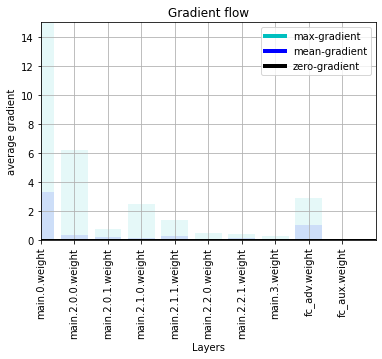

In [90]:
plot_grad_flow(gan.discriminator.named_parameters())

In [194]:
dset.path_to_label

{'/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/201-o.jpg': 10,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/493-bug.jpg': 4,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/154.jpg': 0,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/332.jpg': 0,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/7.jpg': 2,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/392.jpg': 1,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/138.jpg': 11,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/377.jpg': 11,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/386-defense.jpg': 10,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed/gen4_platinum/369.jpg': 2,
 '/home/benoit/Documents/work/DATASETS/pokemon_sprites_processed